In [1]:
nb_bench = 3
col_name = ["func", "start", "end", "filename", "worker", "thread", "process"]

In [2]:
def wasted_time(filename, *, framework):
    df = pd.read_csv(filename, header=None, names=col_name)

    if framework == "spark":
        df["thread"] = df["process"]

    core_used = sum(
        [
            1
            for w in df.worker.unique()
            for i, t in enumerate(df[df.worker == w].thread.unique())
        ]
    )

    df["runtime"] = df.end - df.start
    func_time = df.groupby("func")["runtime"].sum()
    read_time = func_time["read_img"]
    processing_time = func_time["increment"]
    save_time = func_time["save_results"]

    total_time = df.end.max() * core_used

    wasted_time = total_time - (read_time + processing_time + save_time)
    return read_time, processing_time, save_time, wasted_tim

In [3]:
def idle_time(filename, *, framework):
    df = pd.read_csv(filename, header=None, names=col_name)
    if framework == "spark":
        df["thread"] = df["process"]

    by_thread = df.groupby(["worker", "thread"])

    df["runtime"] = df.end - df.start
    func_time = df.groupby("func")["runtime"].sum()
    read_time = func_time["read_img"]
    processing_time = func_time["increment"]
    save_time = func_time["save_results"]

    thread_runtimes = by_thread["runtime"].sum()
    thread_completion = by_thread["end"].max()

    idle_time = (thread_completion - thread_runtimes).sum()
    return read_time, processing_time, save_time, idle_time

In [5]:
from math import sqrt
import os

import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import pandas as pd


def plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, *, f_out=None):
    ## Path to result file
    spark_file = "../{0}/data-{1}/results-spark_{0}-{2}.csv"
    dask_bag_file = "../{0}/data-{1}/results-dask-bag_{0}-{2}.csv"
    dask_delayed_file = "../{0}/data-{1}/results-dask-delayed_{0}-{2}.csv"
    dask_futures_file = "../{0}/data-{1}/results-dask-futures_{0}-{2}.csv"

    # Retrieve file name
    spark = [
        [
            func(spark_file.format(exp_type, nth_bench, exp_name), framework="spark")
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(spark_file.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    dask_bag = [
        [
            func(dask_bag_file.format(exp_type, nth_bench, exp_name), framework="dask")
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(dask_bag_file.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    dask_delayed = [
        [
            func(
                dask_delayed_file.format(exp_type, nth_bench, exp_name),
                framework="dask",
            )
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(dask_delayed_file.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    dask_futures = [
        [
            func(
                dask_futures_file.format(exp_type, nth_bench, exp_name),
                framework="dask",
            )
            for nth_bench in range(1, nb_bench + 1)
            if os.path.exists(dask_futures_file.format(exp_type, nth_bench, exp_name))
        ]
        for exp_name in exp_names
    ]

    def get_stat(data):
        data = [[(0, 0, 0, 0)] * 5 if x == [] else x for x in data]
        rv = []
        for i in range(len(data)):
            packed = list(zip(*data[i]))

            stats = list(zip(map(np.mean, zip(*data[i])), map(np.std, zip(*data[i]))))
            rv.append(stats)
        arr = [*zip(*rv)]

        for i in range(len(arr)):
            tmp = [*zip(*arr[i])]
            arr[i] = {"mean": np.array(tmp[0]), "std": np.array(tmp[1])}
        return arr

    # Calculate statistics
    spark_stat = get_stat(spark)
    dask_bag_stat = get_stat(dask_bag)
    dask_delayed_stat = get_stat(dask_delayed)
    dask_futures_stat = get_stat(dask_futures)

    # Generate plot
    fig, ax = plt.subplots(figsize=(10, 5))

    barWidth = 0.15

    # Set position of bar on X axis
    r1 = np.arange(len(spark))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    read = plt.bar(
        r1,
        spark_stat[0]["mean"],
        yerr=spark_stat[0]["std"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    increment = plt.bar(
        r1,
        spark_stat[1]["mean"],
        yerr=spark_stat[1]["std"],
        bottom=spark_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Spark",
    )
    save = plt.bar(
        r1,
        spark_stat[2]["mean"],
        yerr=spark_stat[2]["std"],
        bottom=spark_stat[1]["mean"] + spark_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    idle = plt.bar(
        r1,
        spark_stat[3]["mean"],
        yerr=spark_stat[3]["std"],
        bottom=spark_stat[2]["mean"] + spark_stat[1]["mean"] + spark_stat[0]["mean"],
        color="blue",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    plt.bar(
        r2,
        dask_bag_stat[0]["mean"],
        yerr=dask_bag_stat[0]["std"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    plt.bar(
        r2,
        dask_bag_stat[1]["mean"],
        yerr=dask_bag_stat[1]["std"],
        bottom=dask_bag_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Dask Bag",
    )
    plt.bar(
        r2,
        dask_bag_stat[2]["mean"],
        yerr=dask_bag_stat[2]["std"],
        bottom=dask_bag_stat[1]["mean"] + dask_bag_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    plt.bar(
        r2,
        dask_bag_stat[3]["mean"],
        yerr=dask_bag_stat[3]["std"],
        bottom=dask_bag_stat[2]["mean"]
        + dask_bag_stat[1]["mean"]
        + dask_bag_stat[0]["mean"],
        color="crimson",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    plt.bar(
        r3,
        dask_delayed_stat[0]["mean"],
        yerr=dask_delayed_stat[0]["std"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    plt.bar(
        r3,
        dask_delayed_stat[1]["mean"],
        yerr=dask_delayed_stat[1]["std"],
        bottom=dask_delayed_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Dask Delayed",
    )
    plt.bar(
        r3,
        dask_delayed_stat[2]["mean"],
        yerr=dask_delayed_stat[2]["std"],
        bottom=dask_delayed_stat[1]["mean"] + dask_delayed_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    plt.bar(
        r3,
        dask_delayed_stat[3]["mean"],
        yerr=dask_delayed_stat[3]["std"],
        bottom=dask_delayed_stat[2]["mean"]
        + dask_delayed_stat[1]["mean"]
        + dask_delayed_stat[0]["mean"],
        color="orange",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    plt.bar(
        r4,
        dask_futures_stat[0]["mean"],
        yerr=dask_futures_stat[0]["std"],
        color="purple",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="\\\\",
    )
    plt.bar(
        r4,
        dask_futures_stat[1]["mean"],
        yerr=dask_futures_stat[1]["std"],
        bottom=dask_futures_stat[0]["mean"],
        color="purple",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        label="Dask Futures",
    )
    plt.bar(
        r4,
        dask_futures_stat[2]["mean"],
        yerr=dask_futures_stat[2]["std"],
        bottom=dask_futures_stat[1]["mean"] + dask_futures_stat[0]["mean"],
        color="purple",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="xxx",
    )
    plt.bar(
        r4,
        dask_futures_stat[3]["mean"],
        yerr=dask_futures_stat[3]["std"],
        bottom=dask_futures_stat[2]["mean"]
        + dask_futures_stat[1]["mean"]
        + dask_futures_stat[0]["mean"],
        color="purple",
        width=barWidth,
        edgecolor="black",
        alpha=0.66,
        hatch="ooo",
    )

    # Add xticks on the middle of the group bars
    plt.xlabel(xlabel, fontweight="bold")
    plt.xticks([r + barWidth/2 for r in r2], xticks_label)
    plt.ylabel("Totaltime")
    plt.ylim([0,160000])

    # Framework legend
    leg1 = plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.02))

    # Function legend
    read_patch = Patch(
        facecolor="gray", edgecolor="black", hatch="\\\\\\", label="Read"
    )
    increment_patch = Patch(facecolor="gray", edgecolor="black", label="Compute")
    save_patch = Patch(facecolor="gray", edgecolor="black", hatch="xxx", label="Write")
    idle_patch = Patch(
        facecolor="gray", edgecolor="black", hatch="ooo", label="Overhead"
    )
    leg2 = plt.legend(
        loc="upper right",
        handles=[read_patch, increment_patch, save_patch, idle_patch],
        bbox_to_anchor=(1.17, 0.78),
    )
    ax.add_artist(leg1)
    
    if f_out:
        plt.savefig("./figures/"+f_out, bbox_inches='tight')
        
        
    plt.show()

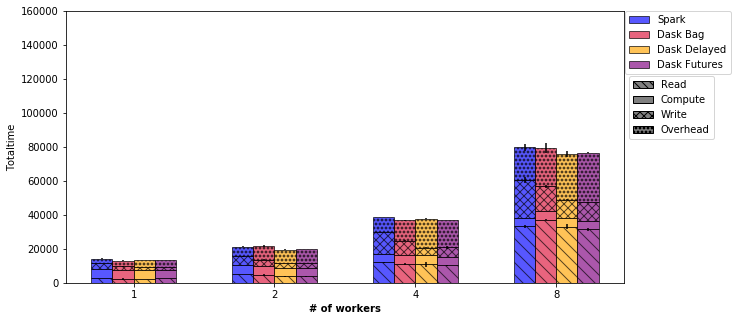

In [6]:
exp_type = "inc"
exp_names = ["1node", "2node", "4node", "baseline"]
xlabel = "# of workers"
xticks_label = ["1", "2", "4", "8"]
func = idle_time
f_out = "inc_idle_worker.png"

plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, f_out=f_out)

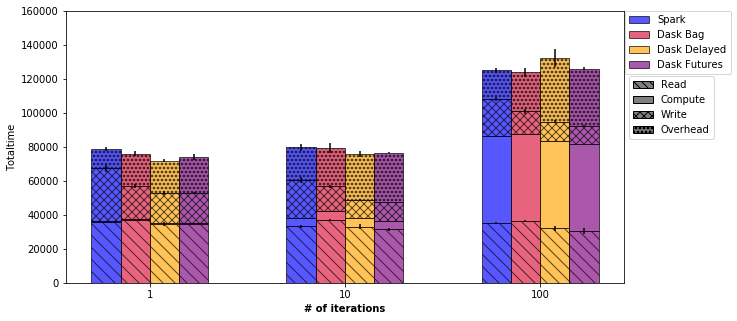

In [7]:
exp_type = "inc"
exp_names = ["1itr", "baseline", "100itr"]
xlabel = "# of iterations"
xticks_label = ["1", "10", "100"]
func = idle_time
f_out = "inc_idle_itr.png"

plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, f_out=f_out)

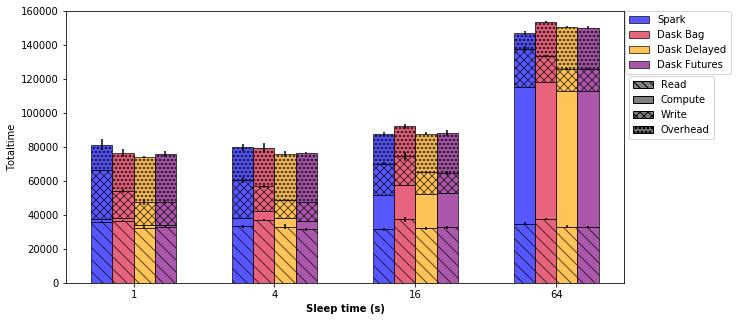

In [8]:
exp_type = "inc"
exp_names = ["1delay", "baseline", "16delay", "64delay"]
xlabel = "Sleep time (s)"
xticks_label = ["1", "4", "16", "64"]
func = idle_time
f_out = "inc_idle_sleep.png"

plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, f_out=f_out)

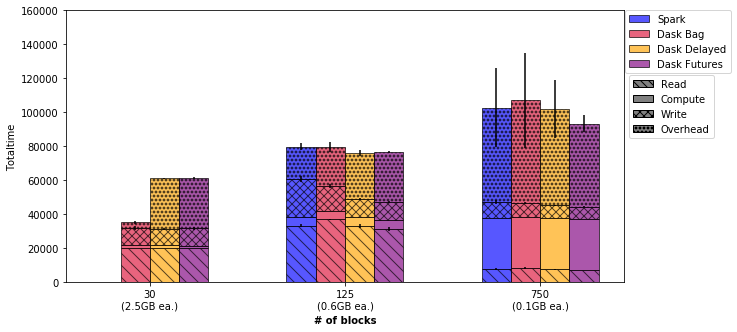

In [9]:
exp_type = "inc"
exp_names = ["30chunks", "baseline", "750chunks"]
xlabel = "# of blocks"
xticks_label = ["30\n(2.5GB ea.)", "125\n(0.6GB ea.)", "750\n(0.1GB ea.)"]
func = idle_time
f_out = "inc_idle_block.png"

plot_timeline(exp_type, exp_names, xlabel, xticks_label, func, f_out=f_out)